PIPELINE


0. Basline with no outliers removed

1. Remove outliers -- EDA here

1. a. baseline with outliers removed

2. Divide to parametric and non-parametric distribution --  

3. Run parametric and non-parametric models  --- TEST ASSUMPTIONS!

4. Table to comapre RSME (used in the competition) ... RF seems to perform best

In [204]:
import numpy as np #installed vers 1.23.0 for compatability with SciPy
from numpy import percentile
import pandas as pd
import sklearn as sk
import seaborn as sns
import os
import sys
import scipy
from scipy.stats import shapiro
from scipy.stats import normaltest
from scipy.stats import anderson
from matplotlib import pyplot as plt
from statsmodels.graphics.gofplots import qqplot
from pandas import read_csv
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
import sklearn.neighbors._base
sys.modules['sklearn.neighbors.base'] = sklearn.neighbors._base #for missingpy, name in most recent sklearn doesn't match
from missingpy import MissForest

In [153]:
tt = pd.read_csv('tt.csv')

In [154]:
tt = tt.drop('State', axis=1).copy()
tt = tt.astype({'Zip': 'object'}).copy()

In [155]:
train = tt.loc[:47438].copy()

In [156]:
train.columns

Index(['Id', 'Sold_Price', 'Type', 'Year_built', 'Heating', 'Cooling',
       'Parking', 'Lot', 'Bedrooms', 'Bathrooms', 'Full_bathrooms',
       'Total_interior_livable_area', 'Total_spaces', 'Garage_spaces',
       'Flooring', 'Tax_assessed_value', 'Annual_tax_amount', 'Listed_Price',
       'Last_Sold_Price', 'Zip', 'Days_Listed', 'Days_Sold', 'Address_RdType',
       'Address_NoLen', 'Summary_Len', 'Schools_Score', 'Schools_Distance',
       'Total_Appliances', 'Hookups'],
      dtype='object')

In [157]:
train = train.drop('Id', axis=1).copy()

In [164]:
train.Year_built.describe()

count    46394.000000
mean      1966.131957
std         30.884746
min       1848.000000
25%       1947.000000
50%       1967.000000
75%       1989.000000
max       2021.000000
Name: Year_built, dtype: float64

In [163]:
train.Year_built = train.Year_built.apply(lambda x: train.Year_built.median() if x < 1800 or x > 2021 else x).copy()

# Identifying quantitative and qualitative 

In [8]:
quantitative = [f for f in train.columns if train.dtypes[f] != 'object']
quantitative.remove('Sold_Price')
qualitative = [f for f in train.columns if train.dtypes[f] == 'object']

In [9]:
quantitative

['Year_built',
 'Lot',
 'Bedrooms',
 'Bathrooms',
 'Full_bathrooms',
 'Total_interior_livable_area',
 'Total_spaces',
 'Garage_spaces',
 'Tax_assessed_value',
 'Annual_tax_amount',
 'Listed_Price',
 'Last_Sold_Price',
 'Days_Listed',
 'Days_Sold',
 'Address_NoLen',
 'Summary_Len',
 'Schools_Score',
 'Schools_Distance',
 'Total_Appliances']

In [10]:
qualitative

['Type',
 'Heating',
 'Cooling',
 'Parking',
 'Flooring',
 'Zip',
 'Address_RdType',
 'Hookups']

# Baseline model peformance

In [214]:
def assess_regression(df_list, name_list):
    out_cells =[]
    i = 0
    for df in df_list:
        mae_total = 0
        mse_total = 0
        X, y = df.drop('Sold_Price', axis=1).copy(), df.Sold_Price.copy()
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)
        model = LinearRegression()
        model.fit(X_train, y_train)
        yhat = model.predict(X_test)
        name = name_list[i]
        shape = df.shape
        for x in range(0,5): #divide final result by 5 to account for stochastic randomness
            mae_total+= mean_absolute_error(y_test, yhat)
            mse_total+= mean_squared_error(y_test, yhat)
        out_cells.append([name, f'{mae_total/5:.3f}', f'{mse_total/5:.3f}', shape])
        i+=1
    out = pd.DataFrame(out_cells, columns=['Data', 'MAE', 'MSE', 'Shape']).copy()
    return out

# TTS before modification ... NaN columns must not be dropped but maintained for use 

In [55]:
bl1 = train.copy()
bl1 = pd.get_dummies(data=bl1, columns=qualitative, drop_first=True)
bl1_X = bl1.drop('Sold_Price', axis=1).copy()
bl1_y = bl1.Sold_Price.copy()
bl1_X_train, bl1_X_test, bl1_y_train, bl1_y_test = train_test_split(bl1_X, bl1_y, test_size=0.2, random_state=1)

C:\Users\euana\anaconda3\lib\site-packages\pandas\core\algorithms.py:798: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  uniques = Index(uniques)


In [56]:
frames = [bl1_X_train, bl1_y_train]

In [57]:
out = pd.concat(frames)

In [58]:
out = out.rename(columns={0: 'Sold_Price'}).copy()

Drop NaN does not work as all rows are dropped, so replace with 0

In [61]:
out = out.fillna(0).copy()

In [65]:
bl1_X_train = out.drop('Sold_Price', axis=1)
bl1_y_train = out['Sold_Price'].copy()

The actual test data for competition does not have NaN values, to avoid data leakeage here we will fillna with the median value of each column in the test data

In [72]:
bl1_X_test.isna().sum()

Year_built             224
Lot                   2896
Bedrooms                 0
Bathrooms              722
Full_bathrooms        1578
                      ... 
Address_RdType_St        0
Address_RdType_Ter       0
Address_RdType_Trl       0
Address_RdType_Way       0
Hookups_Y                0
Length: 118, dtype: int64

In [68]:
model = LinearRegression()
model.fit(bl1_X_train, bl1_y_train)
yhat = model.predict(bl1_X_test)
bl1_mae = 0
bl1_mse = 0
for n in range (0,5):
    bl1_mae += mean_absolute_error(bl1_y_test, yhat)
    bl1_mse += mean_squared_error(bl1_y_test, yhat)
bl1_results= [round(bl1_mae/5,3), round(bl1_mse/5,3)]

ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

## Baseline Model 2 -- all NaNs imputed with MissForest and categories one-hot encoded

# !!! need to impute X train only

In [282]:
bl2 = train.copy()
bl2 = pd.get_dummies(data=bl2, columns=qualitative, drop_first=True)
bl2_X = bl2.drop('Sold_Price', axis=1).copy()
imputer = MissForest()
X_imputed = imputer.fit_transform(bl2_X)
bl2_X_imputed = pd.DataFrame(X_imputed, columns=bl2_X.columns).round(2)
bl2_y = bl2.Sold_Price.copy()
bl2_X_train, bl2_X_test, bl2_y_train, bl2_y_test = train_test_split(bl2_X_imputed, bl2_y, test_size=0.2, random_state=1)
model = LinearRegression()
model.fit(bl2_X_train, bl2_y_train)
yhat = model.predict(bl2_X_test)
for n in range (0,5):
    mae += mean_absolute_error(bl2_y_test, yhat)
    mse += mean_squared_error(bl2_y_test, yhat)
mae, mse = round(mae/5,3), round(mse/5,3)
print(mae, mse)

C:\Users\euana\anaconda3\lib\site-packages\pandas\core\algorithms.py:798: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  uniques = Index(uniques)
C:\Users\euana\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:396: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
C:\Users\euana\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:396: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
C:\Users\euana\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:396: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
C:\Users\euana\anaconda3\lib\site-packages\sklearn\ensemble\_forest.

Iteration: 0


C:\Users\euana\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:396: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
C:\Users\euana\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:396: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
C:\Users\euana\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:396: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
C:\Users\euana\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:396: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
C:\Users\euana\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:396: FutureWarning: C

Iteration: 1


C:\Users\euana\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:396: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
C:\Users\euana\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:396: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
C:\Users\euana\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:396: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
C:\Users\euana\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:396: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
C:\Users\euana\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:396: FutureWarning: C

Iteration: 2


C:\Users\euana\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:396: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
C:\Users\euana\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:396: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
C:\Users\euana\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:396: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
C:\Users\euana\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:396: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
C:\Users\euana\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:396: FutureWarning: C

Iteration: 3


C:\Users\euana\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:396: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
C:\Users\euana\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:396: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
C:\Users\euana\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:396: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
C:\Users\euana\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:396: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
C:\Users\euana\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:396: FutureWarning: C

Iteration: 4
297169.837 7808084415275.614


In [283]:
bl2_results =  [mae, mse] 
# bl2_mae, bl2_mse = round(mae/5,3), round(mse/5,3)

# Removing outliers

## IQR

## LOF/KNN

# Testing for normality

In [297]:
def normality_tests(df, quantitative):
    Feature = []
    Shapiro_Wilk = []
    K2_Test = []
    Anderson_Darling = []
    for x in quantitative:
        Feature.append(x)
        Shapiro_Wilk.append(shapiro(df[x].dropna())[1])
        K2_Test.append(normaltest(df[x].dropna())[1])
        result = anderson(df[x].dropna())
        Anderson_Darling.append('Reject H0' if result.statistic < result.critical_values[2] else 'Failed to reject H0')
    print(f"H0: Distribution is Gaussian. If p > 0.05 means it is very likely, not certain, the distribution is Gaussian.\nShapiro-Wilk p-value may not be accurate when N > 5000. The DataFrame has {train.shape[0]} values.\nAnderson-Darling at 0.05 signifigance level.")
    out = pd.DataFrame(data=[Shapiro_Wilk, K2_Test, Anderson_Darling], index=['Shapiro-Wilk','K^2 Test','Anderson-Darling'], columns=Feature)
    out = out.transpose().copy()
    out = out.style.applymap(lambda x: "background-color: red" if type(x) != str and x<0.05 or type(x) == str and x =='Reject H0' else "background-color: green")
    return out

In [298]:
normality_tests(bl1_X_train, quantitative)

C:\Users\euana\anaconda3\lib\site-packages\scipy\stats\_morestats.py:1800: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


H0: Distribution is Gaussian. If p > 0.05 means it is very likely, not certain, the distribution is Gaussian.
Shapiro-Wilk p-value may not be accurate when N > 5000. The DataFrame has 47439 values.
Anderson-Darling at 0.05 signifigance level.


,Shapiro-Wilk,K^2 Test,Anderson-Darling
Year_built,0.000000,0.000000,Failed to reject H0
Lot,0.000000,0.000000,Failed to reject H0
Bedrooms,0.000000,0.000000,Failed to reject H0
Bathrooms,0.000000,0.000000,Failed to reject H0
Full_bathrooms,0.000000,0.000000,Failed to reject H0
Total_interior_livable_area,0.000000,0.000000,Failed to reject H0
Total_spaces,0.000000,0.000000,Failed to reject H0
Garage_spaces,0.000000,0.000000,Failed to reject H0
Tax_assessed_value,0.000000,0.000000,Failed to reject H0
Annual_tax_amount,0.000000,0.000000,Failed to reject H0


In [23]:
def normality_graphic(x):
    h= plt.hist(x, bins='auto')
    qq=qqplot(x, line='45')
    return h[2], qq

#need to expand hist to show full range of values ... take total number of unique values and divide by x? some function of unique and range?

# Detecting and removing outliers

We can't assume a Gaussian distribution as Hard Fail for all quantiative features. 

## Assumptions

* Non-parametric, the distribution is not Gaussian

## IQR

https://machinelearningmastery.com/how-to-use-statistics-to-identify-outliers-in-data/

https://www.geeksforgeeks.org/box-plot-in-python-using-matplotlib/

In [84]:
def iqr(x, k, w, h):
    #k is for k factor, above what factor of IQR do we define value as being an outlier
    q25, q75 = percentile(x, 25), percentile(x, 75)
    iqr = q75 - q25
    cut_off = iqr*k
    lower, upper = q25 - cut_off, q75 + cut_off
    outliers = [v for v in x if v < lower or v > upper]
    non_outliers = [v for v in x if v >= lower and v <= upper]
    print(f"""
    Percentiles: 25th={round(q25,2)}, 75th={round(q75, 2)}, IQR={round(iqr, 2)}
    Identified outliers: {len(outliers)}
    Non-outliers: {len(non_outliers)}
    """)
    sns.distplot(non_outliers)
    fig = plt.figure(figsize=(w,h))
#     plt.boxplot(x)
    plt.boxplot(non_outliers)
    return plt.show()

In [78]:
train.Sold_Price.describe().apply(lambda x: format(x, 'f'))

count       47439.000000
mean      1296050.499146
std       1694452.203348
min        100500.000000
25%        565000.000000
50%        960000.000000
75%       1525000.000000
max      90000000.000000
Name: Sold_Price, dtype: object

C:\Users\euana\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='Sold_Price', ylabel='Density'>

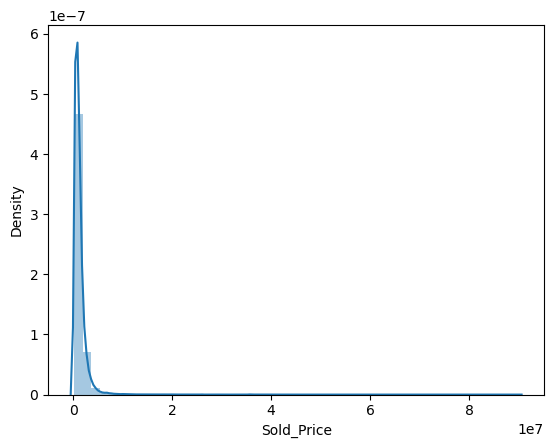

In [83]:
sns.distplot(train.Sold_Price)


    Percentiles: 25th=565000.0, 75th=1525000.0, IQR=960000.0
    Identified outliers: 2814
    Non-outliers: 44625
    


C:\Users\euana\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


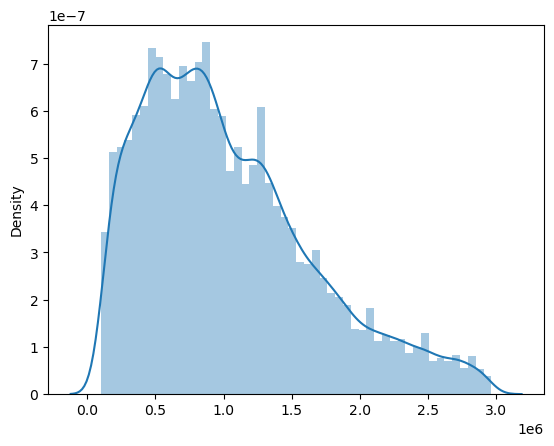

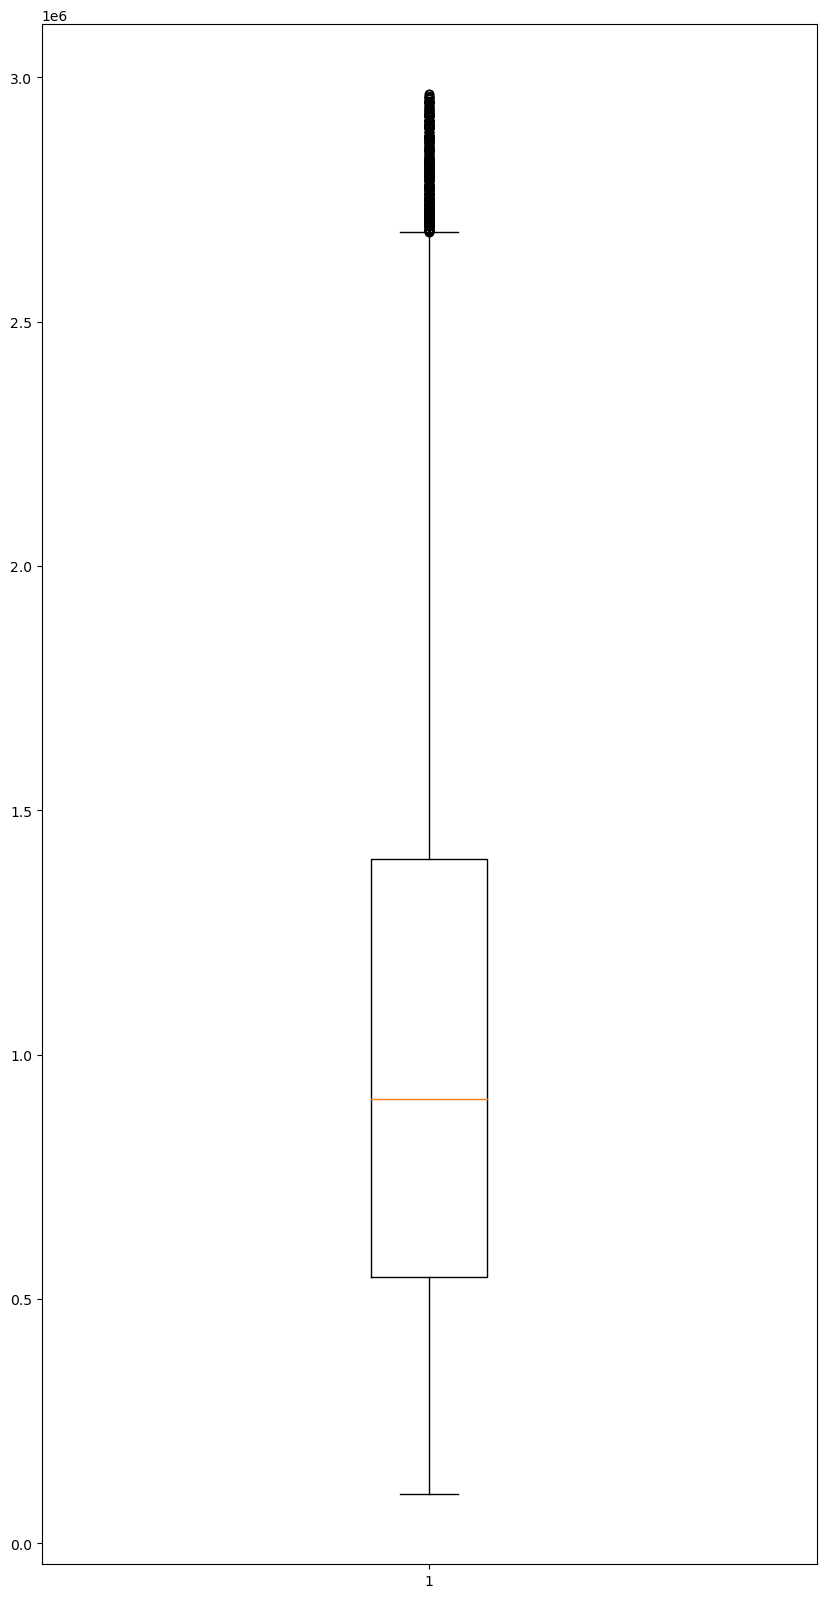

In [85]:
iqr(train.Sold_Price, 1.5, 10,20)

# Identify and modify outliers

Plan of attack ... non-parametric, use IQR compare with baseline and test for normality, repeat for suitable automatic methods ... then transform to normal distribution and compare with previous models ... remember TTS .... goal is to achieve normal distribution then minimise error ... interpreting linear regression output? 

## Non-Parametric

### Inter-Quartile Range

In [226]:
train_iqr = train.copy()
train_iqr = pd.get_dummies(data=train_iqr, columns=qualitative, drop_first=True)
train_iqr_X = train_iqr.drop('Sold_Price', axis=1).copy()
train_iqr_y = train_iqr.Sold_Price.copy()
iqr_X_train, iqr_X_test, iqr_y_train, iqr_y_test = train_test_split(train_iqr_X, train_iqr_y, test_size=0.2, random_state=1)

C:\Users\euana\anaconda3\lib\site-packages\pandas\core\algorithms.py:798: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  uniques = Index(uniques)


In [227]:
iqr_X_train_quantitative = iqr_X_train[quantitative]

In [228]:
iqr_X_train_quantitative = iqr_X_train_quantitative.fillna(iqr_X_train_quantitative.median()).copy()

In [229]:
for x in iqr_X_train_quantitative.columns:
    iqr_X_train_quantitative[x] = iqr_X_train_quantitative[x].astype('int64').copy()

In [230]:
for x in iqr_X_train_quantitative.columns:
        q25, q75 = percentile(iqr_X_train_quantitative[x], 25), percentile(iqr_X_train_quantitative[x], 75)
        iqr = q75 - q25
        cutoff = iqr * 1.5
        lower, upper = q25 - cutoff, q75 + cutoff
        outliers = [v for v in iqr_X_train_quantitative[x] if v < lower or v > upper]
        iqr_X_train_quantitative[x] = iqr_X_train_quantitative[x].apply(lambda a: iqr_X_train_quantitative[x].median() if a in outliers else a).copy()

In [240]:
iqr_X_train = pd.concat([iqr_X_train_quantitative, iqr_X_train]).copy()

In [249]:
iqr_X_train_quantitative.columns

Index(['Year_built', 'Lot', 'Bedrooms', 'Bathrooms', 'Full_bathrooms',
       'Total_interior_livable_area', 'Total_spaces', 'Garage_spaces',
       'Tax_assessed_value', 'Annual_tax_amount', 'Listed_Price',
       'Last_Sold_Price', 'Days_Listed', 'Days_Sold', 'Address_NoLen',
       'Summary_Len', 'Schools_Score', 'Schools_Distance', 'Total_Appliances'],
      dtype='object')

In [257]:
iqr_X_train = iqr_X_train.drop(iqr_X_train.loc[:, 'Year_built': 'Total_Appliances'], axis=1).copy()

In [259]:
iqr_X_train = pd.concat([iqr_X_train_quantitative, iqr_X_train]).copy()

In [260]:
iqr_X_train.describe()

,Year_built,Lot,Bedrooms,Bathrooms,Full_bathrooms,Total_interior_livable_area,Total_spaces,Garage_spaces,Tax_assessed_value,Annual_tax_amount,...,Address_RdType_Dr,Address_RdType_Ln,Address_RdType_Loop,Address_RdType_Pl,Address_RdType_Rd,Address_RdType_St,Address_RdType_Ter,Address_RdType_Trl,Address_RdType_Way,Hookups_Y
count,37951.000000,37951.000000,37951.000000,37951.000000,37951.0,37951.000000,37951.000000,37951.000000,3.795100e+04,37951.000000,...,37951.000000,37951.000000,37951.000000,37951.000000,37951.000000,37951.000000,37951.000000,37951.000000,37951.000000,37951.000000
mean,1966.091302,6352.851862,2.545282,2.194224,2.0,1621.383047,1.261917,1.246713,5.779933e+05,7479.962952,...,0.144924,0.044110,0.002925,0.024084,0.073858,0.162130,0.007879,0.002451,0.049906,0.433928
std,30.392613,1451.576333,0.961361,0.784322,0.0,591.609286,1.116206,1.083923,3.900243e+05,4776.436534,...,0.352029,0.205341,0.054003,0.153311,0.261544,0.368575,0.088412,0.049443,0.217755,0.495622
min,1884.000000,2225.000000,1.000000,1.000000,2.0,1.000000,0.000000,0.000000,0.000000e+00,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1947.000000,6098.000000,2.000000,2.000000,2.0,1201.000000,0.000000,0.000000,2.758440e+05,3816.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1967.000000,6500.000000,3.000000,2.000000,2.0,1565.000000,1.000000,1.000000,5.466270e+05,7125.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1989.000000,6500.000000,3.000000,3.000000,2.0,1924.000000,2.000000,2.000000,7.749320e+05,9891.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
max,2021.000000,11384.000000,4.000000,4.000000,2.0,3443.000000,5.000000,5.000000,1.827144e+06,22698.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [231]:
q25, q75 = percentile(iqr_y_train, 25), percentile(iqr_y_train, 75)
iqr = q75 - q25
cutoff = iqr * 1.5
lower, upper = q25 - cutoff, q75 + cutoff
outliers = [v for v in iqr_y_train if v < lower or v > upper]
iqr_y_train = iqr_y_train.apply(lambda a: iqr_y_train.median() if a in outliers else a).copy()

In [236]:
iqr_y_train.describe().apply(lambda x: format(x, 'f'))

count      37951.000000
mean     1030078.801244
std       611750.781837
min       100500.000000
25%       561500.000000
50%       960000.000000
75%      1358000.000000
max      2969000.000000
Name: Sold_Price, dtype: object

then rejoin to qualitative and test with random forest

In [213]:
iqr_X_train_quantitative.describe().apply(lambda s: s.apply(lambda x: format(x, 'f')))

,Year_built,Lot,Bedrooms,Bathrooms,Full_bathrooms,Total_interior_livable_area,Total_spaces,Garage_spaces,Tax_assessed_value,Annual_tax_amount,Listed_Price,Last_Sold_Price,Days_Listed,Days_Sold,Address_NoLen,Summary_Len,Schools_Score,Schools_Distance,Total_Appliances
count,37951.000000,37951.000000,37951.000000,37951.000000,37951.000000,37951.000000,37951.000000,37951.000000,37951.000000,37951.000000,37951.000000,37951.000000,37951.000000,37951.000000,37951.000000,37951.000000,37951.000000,37951.000000,37951.000000
mean,1966.091302,6500.000000,2.545282,2.194224,2.000000,1545.933019,1.261917,1.246713,525196.703829,6842.206345,935730.544254,593908.085927,267.531501,1355.497826,3.706490,690.699560,5.227899,0.583647,3.113304
std,30.392613,0.000000,0.961361,0.784322,0.000000,482.108440,1.116206,1.083923,311476.955412,3835.015492,481323.117127,9731.022962,111.919973,1587.034284,0.731407,331.482247,1.986966,0.631125,2.718379
min,1884.000000,6500.000000,1.000000,1.000000,2.000000,240.000000,0.000000,0.000000,0.000000,0.000000,0.000000,521000.000000,62.000000,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000
25%,1947.000000,6500.000000,2.000000,2.000000,2.000000,1204.000000,0.000000,0.000000,275844.000000,3816.000000,570000.000000,595000.000000,179.000000,0.000000,3.000000,392.000000,4.000000,0.000000,0.000000
50%,1967.000000,6500.000000,3.000000,2.000000,2.000000,1565.000000,1.000000,1.000000,546627.000000,7125.000000,949000.000000,595000.000000,263.000000,1086.000000,4.000000,728.000000,5.000000,1.000000,3.000000
75%,1989.000000,6500.000000,3.000000,3.000000,2.000000,1800.000000,2.000000,2.000000,691268.000000,8823.500000,1200000.000000,595000.000000,342.000000,2121.000000,4.000000,975.000000,7.000000,1.000000,5.000000
max,2021.000000,6500.000000,4.000000,4.000000,2.000000,2820.000000,5.000000,5.000000,1388220.000000,17341.000000,2265000.000000,639000.000000,609.000000,6161.000000,5.000000,1845.000000,10.000000,2.000000,12.000000


## Winsorization

## Automatic outlier detection

https://machinelearningmastery.com/model-based-outlier-detection-and-removal-in-python/

Isolation Forest 

## Assessing the methods

will need to create and run the model for this?

# Comparison table

In [300]:
comparison_table = pd.DataFrame(np.array([['bl1', 'Linear Regression', bl1_results[0], bl1_results[1], bl1_X_train.shape, 'No'],
                                        ['bl2', 'Linear Regression', bl2_results[0], bl2_results[1], bl2_X_train.shape, 'No']]),
                                columns=['Name', 'Model', 'MAE', 'MSE', 'Shape', 'Gaussian?'])
comparison_table

C:\Users\euana\AppData\Local\Temp\ipykernel_7700\603841553.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  comparison_table = pd.DataFrame(np.array([['bl1', 'Linear Regression', bl1_results[0], bl1_results[1], bl1_X_train.shape, 'No'],


,Name,Model,MAE,MSE,Shape,Gaussian?
0,bl1,Linear Regression,218546.008,1514185846084.686035,"(13320, 112)",No
1,bl2,Linear Regression,297169.837,7808084415275.614258,"(37951, 118)",No
